In [134]:
from MMT_reduce_module import *

In [135]:
from __future__ import print_function
import numpy as np
import scipy as sp
import scipy.ndimage
from astropy.io import fits
import sys
import numpy.ma as ma
import math
import pidly
import os
import glob
import time
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()


## MMT_reduce_module Testing

#### The purpose of this notebook is to test functions in the MMT module one-by-one and examine the outputs at each step.

Major to-do items (April 4, 2019): 

* Fix saturated data!
    * Examine how sky frames are being made 
    * Examine how sky subtraction is being performed on science data
    * Determine best practice of aligning saturated frames
    * plt.imshow reduced steps
    * Stacking size issue 
    
* Determine how flatfield generation is being done and improve if need be
    * Debug negative dark frames/negative flat frame issues?

In [136]:
pwd

'/Users/scorona/Desktop/TEST'

In [137]:
ls

Calibrations/                     TestingNotebook_MMT_Module.ipynb*
HIP_Test/                         __pycache__/


### Set up paths to raw data and definitions

In [171]:
path_to_raw_sci = './HIP_Test/HIP19337/'
path_to_raw_darks = './Calibrations/darks/dark_13/30.0/'
path_to_raw_flats = './Calibrations/flat/30.0/'
objname = 'HIP19337_TEST_30s'
flattype = 1
saturated = 1
alignflag = 1
imsize = 1024

## The following cells are each of the steps of the reduce_raw_sci function

In [141]:
# Make list of science frames and check exposure time 
scilist = glob.glob(path_to_raw_sci + 'im*.fits')

print(f"Number of science frames found: {len(scilist)} \n")


Number of science frames found: 5 



In [142]:
scitimes = [fits.getheader(im, ignore_missing_end = True)['EXPTIME'] for im in scilist]

# check if all of the exposure times in the current directory are the same:
if all(x == scitimes[0] for x in scitimes):
    print("Science frame exposure time: " + str(scitimes[0]) + "\n")
else:
    raise Exception("Exposure times for given list of files do not match. \
    You may need to make/define separate subfolders for different exptimes.")

sci_exptime = scitimes[0]

n = len(scilist)


# get header from science frames to work with
sciheader = fits.getheader(scilist[0])


Science frame exposure time: 30.0



In [143]:
# check for datacubes
if len(fits.getdata(scilist[0]).shape) == 3: # check for data cubes of science frames
    sciarray = np.zeros([imsize,imsize,n*fits.getdata(scilist[0]).shape[0]])
else:
    sciarray = np.zeros([imsize,imsize,n])

if len(fits.getdata(scilist[0]).shape) == 3: # check for data cubes of science frames    
    totalframes = n*fits.getdata(scilist[0]).shape[0]
else:
    totalframes = n

print(sciarray)

[[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 ...

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  ...
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]


In [144]:
# in case data were rotated during observing sequence, set up empty array of rotation angles
angle = np.zeros(totalframes)

im_index = 0

for ii in range(0, n):
    
    im = fits.getdata(scilist[ii], ignore_missing_end=True)
    header = fits.getheader(scilist[ii],ignore_missing_end=True)
    
    if len(im.shape) == 3: # check for data cubes of science frames
        assert not np.any(np.isnan(im))
        for jj in range(0, im.shape[0]):
            sciarray[:,:,im_index] = im[jj,:,:]
            angle[im_index] = (header['PA'] - header['ROT']) * (np.pi/180.0)
            im_index += 1
    else: 
        sciarray[:,:,ii] = im  
        angle[ii] = (header['PA'] - header['ROT']) * (np.pi/180.0)
    header = fits.getheader(scilist[ii], ignore_missing_end=True)





In [145]:
print(angle)
print(im)

[1.75390112 1.68817295 1.73067641 1.71732743 1.70264024]
[[   0 1047  932 ...  704  719  717]
 [   0  868  843 ...  715  709  769]
 [   0  703  734 ...  727  789  763]
 ...
 [   0  822  878 ...  839  904 1222]
 [   0  812  845 ...  839 1023 1543]
 [   0  707  856 ...  979 1285 1568]]


Creating and applying master darks and flats...

Found 11 darks with exposure times of 30.0. 



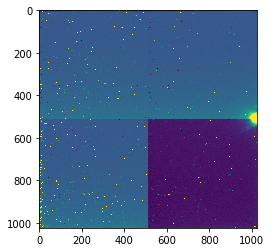

In [146]:
#MASTER_DARK

print("Creating and applying master darks and flats...\n")    

# create master dark matching science exposure times
med_dark = dark_combine(path_to_raw_darks, sci_exptime, imsize, objname) 

vmin, vmax = interval.get_limits(med_dark)
plt.imshow(med_dark, vmin=vmin, vmax=vmax)

In [147]:

# subtract off the median dark frame from each of the science frames
for ii in range (0, totalframes):
    sciarray[:,:,ii] -= med_dark


Flatfield exposure time: 30.0



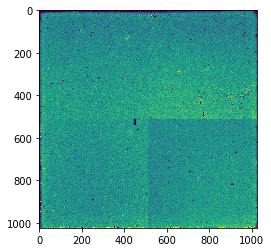

In [148]:
#MEDIAN_AND_MASTER_FLAT

# create the masterflat 
med_flat, master_flat, flatheader = process_flats(path_to_raw_flats, path_to_raw_darks, imsize, flattype, objname)

vmin, vmax = interval.get_limits(med_flat)
plt.imshow(med_flat, vmin=vmin, vmax=vmax)

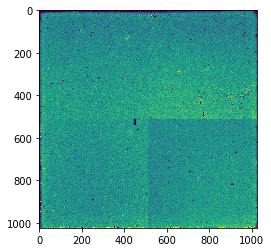

In [149]:
vmin, vmax = interval.get_limits(master_flat)
plt.imshow(master_flat, vmin=vmin, vmax=vmax)

In [150]:

# divide each science frame by the masterflat frame
for ii in range(0, totalframes):
    sciarray[:,:,ii] /= master_flat




Creating bad pixel map and correcting for bad pixels and cosmic rays. 
 This may take a moment... 



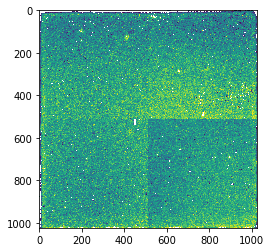

In [151]:
#BAD_PIXEL_MAP

print("Creating bad pixel map and correcting for bad pixels and cosmic rays. \n",
     "This may take a moment... \n") 

# create bad pixel map
badflat = badpixelmap(med_flat, objname, flatheader)  

vmin, vmax = interval.get_limits(badflat)
plt.imshow(badflat, vmin=vmin, vmax=vmax)

In [152]:

# correct the bad pixels and cosmic rays
reduced_sciarray = correct_bad_pixels(sciarray, badflat)


# some housekeeping to free memory later
#del sciarray
print(reduced_sciarray)

Correcting image #0
Correcting image #1
Correcting image #2
Correcting image #3
Correcting image #4
[[[1048.24178144  807.282307   1018.29201625 1014.20795736 1038.7123107 ]
  [1057.32545774  838.61309255 1062.50208177 1032.11677723 1050.8546777 ]
  [1071.31108523  843.98409885 1071.31108523 1050.64982041 1076.30371297]
  ...
  [1080.77742014  904.66042942 1048.31895254 1076.70056726 1068.92478824]
  [1076.94636724  904.66042942 1048.31895254 1076.94636724 1068.92478824]
  [1076.94636724  909.77846389 1057.86124174 1076.94636724 1062.55538276]]

 [[1048.24178144  807.282307   1018.29201625 1014.20795736 1038.7123107 ]
  [1057.32545774  838.61309255 1062.50208177 1032.11677723 1050.8546777 ]
  [1071.31108523  843.98409885 1071.31108523 1050.64982041 1076.30371297]
  ...
  [1080.77742014  909.77846389 1045.35278383 1074.68529337 1074.68858218]
  [1080.71274882  909.77846389 1044.90805521 1076.94636724 1074.68858218]
  [1080.93794335  909.77846389 1042.57237352 1076.94636724 1078.30472059

In [157]:
ls

Calibrations/
HIP19337_TEST_30s_2016-10-13_masterdark_30.0s.fits
HIP19337_TEST_30s_2016-10-13_masterskyA.fits
HIP19337_TEST_30s_2016-10-13_masterskyB.fits
HIP19337_TEST_30s_2016-10-14_badflat.fits
HIP19337_TEST_30s_2016-10-14_masterlampflat.fits
HIP19337_TEST_30s_2016-10-14_medianlampflat.fits
HIP_Test/
TestingNotebook_MMT_Module.ipynb*
__pycache__/


In [154]:
#MASTER_SKY_A_AND_B
print("Creating master sky from science frames...\n") 

# create median sky from stack of science images
sky_output = create_sky_frames(reduced_sciarray, sciheader, objname, angle)



Creating master sky from science frames...



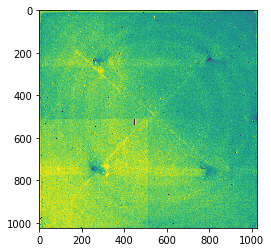

In [158]:
master_skyB = glob.glob('HIP19337_TEST_30s_2016-10-13_masterskyB.fits')
master_skyB_data = fits.getdata(master_skyB[0])
vmin, vmax = interval.get_limits(master_skyB_data)
plt.imshow(master_skyB_data, vmin=vmin, vmax=vmax)

In [159]:
# apply sky subtraction to each science image 
skysub_science_array, rot_flag = sky_subtract(reduced_sciarray, sky_output, angle)

In [160]:
rot_flag

1

In [161]:
#INDIVIDUAL_REDUCED_SCI_IMAGES

# initialize blank list to hold all of the reduced science image names
scinames_list = []


for ii in range(0, totalframes):
    print(f"Saving reduced frame #{ii}")
    sciname = 'reducedsci_00' + str(ii) + '.fits'
    if ii >= 10:
        sciname = 'reducedsci_0' + str(ii) + '.fits'
    if ii >= 100:
        sciname = 'reducedsci_' + str(ii) + '.fits'
    fits.writeto(sciname, skysub_science_array[:,:,ii], sciheader, overwrite = True, output_verify='silentfix')
    scinames_list.append(sciname)
t1=time.time()

Saving reduced frame #0
Saving reduced frame #1
Saving reduced frame #2
Saving reduced frame #3
Saving reduced frame #4


In [173]:
!export XPA_METHOD='unix'

In [174]:
# get current directory where reduced frames are written
current_dir = os.getcwd()

# measure star positions in all of the images
xcen, ycen = measure_star_centers(skysub_science_array[:,:,1:3], scinames_list[1:3], sciheader, saturated, alignflag, current_dir, saveframes = True)

% Compiled module: MRDFITS.
% Compiled module: FXPOSIT.
% Compiled module: MRD_HREAD.
% Compiled module: FXPAR.
% Compiled module: GETTOK.
% Compiled module: VALID_NUM.
% Compiled module: MRD_SKIP.
% Compiled module: ARRAY_INDICES.
% Compiled module: DS9.
% Compiled module: DS9_INIT.
% Compiled module: DS9__DEFINE.
% FLOAT: Variable is undefined: IMG.
% Execution halted at: DS9::SETIMAGE     189
   /Users/astrolab/Follette-group/IDL_extras/public_idl/ds94idl/ds9__define.p
  ro
%                      DS9::DISPIMAGE    219
   /Users/astrolab/Follette-group/IDL_extras/public_idl/ds94idl/ds9__define.p
  ro
%                      DS9                48
   /Users/astrolab/Follette-group/IDL_extras/public_idl/ds94idl/ds9.pro
%                      $MAIN$          
IDL>  

error: (25, 'Inappropriate ioctl for device')

In [167]:
print('xcen:', xcen, 'ycen:', ycen)

xcen: [541.19519402 290.54836183] ycen: [488.53095505 248.36065381]


In [169]:
#SHIFTED_IMAGES
#STACKED
#FINAL
t0=time.time()
# final step (!) - shift and combine all of the images.
rotate_shift_align(xcen, ycen, angle, skysub_science_array[:,:,1:3], objname, sciheader, current_dir, imsize=1024)

t1 = time.time()
timetaken = (t1-t0)/60.
print(f"Completed reduction of {totalframes} images in {timetaken} minutes.")






1243 1468
Shifting image 0 of 2...
Shifting image 1 of 2...
% Compiled module: MRDFITS.
% Compiled module: FXPOSIT.
% Compiled module: MRD_HREAD.
% Compiled module: FXPAR.
% Compiled module: GETTOK.
% Compiled module: VALID_NUM.
% Compiled module: MRD_SKIP.
% Compiled module: MWRFITS.
% Compiled module: FXADDPAR.
% Compiled module: SXDELPAR.
Completed reduction of 5 images in 6.3396215836207075 minutes.


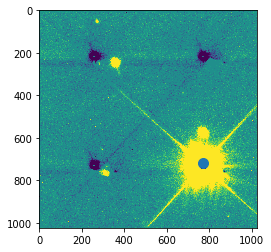

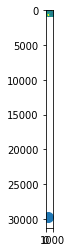

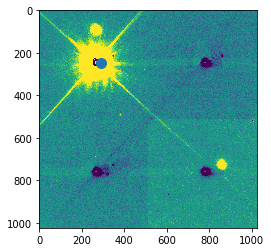

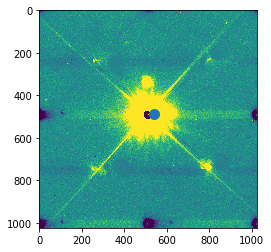

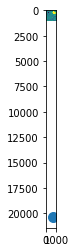

In [170]:
reduced_array = glob.glob('reduced*')

for ii in reduced_array:
    reducedsci = fits.getdata(ii)
    reducedsci_header = fits.getheader(ii)
    
    xcen = reducedsci_header['CRPIX1A']
    ycen = reducedsci_header['CRPIX2A']
    
    vmin1, vmax1 = interval.get_limits(reducedsci)
    plt.imshow(reducedsci, vmin=vmin1, vmax=vmax1)
    plt.plot(xcen, ycen, marker = 'o', markersize = 10)
    plt.show()



In [58]:
n = len(scinames_list)

xcen = np.zeros(n)
ycen = np.zeros(n)

idl = pidly.IDL('/Applications/exelis/idl/bin/idl')
idl_changedir = 'cd, ' + f'"{current_dir}"'
idl(idl_changedir)

for ii in range(0, 1):
    # idl('name = "'+sciname+'"')
    idl('name = "'+ scinames_list[ii] +'"')
    idl('im=MRDFITS(name,0,/FSCALE,/SILENT)')
    idl('tmp=SMOOTH(im,21,/EDGE_TRUNCATE)')
    idl('tmp[0:100,*]=0.0')
    idl('tmp[924:1023,*]=0.0')
    idl('tmp[*,0:100]=0.0')
    idl('tmp[*,1000:1023]=0.0')
    idl('foo=MAX(tmp,ind,/NAN)')
    idl('ind=ARRAY_INDICES(tmp,ind)')
    idl('print, foo')
    
    if saturated == 0:
        idl('GCNTRD,im[ind[0]-20:ind[0]+20,ind[1]-20:ind[1]+20],20,20,xcen,ycen,3.0')
        idl('xcen += ind[0]-20.0')
        idl('ycen += ind[1]-20.0')
        xcen[ii], ycen[ii] = idl.xcen, idl.ycen
    else:
        idl('x=ind[0]')
        idl('y=ind[1]')
        idl('sim = im[x-20:x+20,y-20:y+20]')
        idl('weights = (sim*0.0)+1.0')
        idl('weights[WHERE(sim ge 0.7*MAX(sim,/NAN))]=0.0')
        idl('fit=MPFIT2DPEAK(sim,A,WEIGHTS=weights)')
        idl('xcen = A[4]+(x-20.0)')
        idl('ycen = A[5]+(y-20.0)')
        xcen[ii], ycen[ii] = idl.xcen, idl.ycen
        idl('print, A[5]')

print(xcen[ii],ycen[ii])

% Compiled module: MRDFITS.
% Compiled module: FXPOSIT.
% Compiled module: MRD_HREAD.
% Compiled module: FXPAR.
% Compiled module: GETTOK.
% Compiled module: VALID_NUM.
% Compiled module: MRD_SKIP.
% Compiled module: ARRAY_INDICES.
       9477.2254
% Compiled module: MPFIT2DPEAK.
% Compiled module: MPFIT.
% Compiled module: MPFIT2DFUN.
       37.248290
314.4158644195775 754.2482904510331


In [56]:
idl.A

array([-6.43072689e+07,  6.47010360e+07,  9.00747380e+02,  1.84956460e+05,
        2.35163237e+01,  2.02758503e+04,  0.00000000e+00])

In [ ]:

reduce_raw_sci(path_to_raw_sci, path_to_raw_darks, path_to_raw_flats, objname, flattype, saturated, alignflag, imsize = 1024)